In [1]:
!pip install -q segmentation-models-pytorch
!pip install -q albumentations


In [2]:
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
from tqdm import tqdm

# Ensure that these paths are correct based on your Kaggle input directory
image_dir = '/kaggle/input/kvasier-seg/new_data/train/images/'
mask_dir = '/kaggle/input/kvasier-seg/new_data/train/masks/'
valid_image_dir = '/kaggle/input/kvasier-seg/new_data/valid/images/'
valid_mask_dir = '/kaggle/input/kvasier-seg/new_data/valid/masks/'
test_image_dir = '/kaggle/input/kvasier-seg/new_data/test/images/'
test_mask_dir = '/kaggle/input/kvasier-seg/new_data/test/masks/'

# Define transforms for training and validation
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Dataset class
class PolypDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))  # Ensure matching names

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Tensor, shape [3, H, W]
            mask = augmented['mask'].unsqueeze(0) / 255.0  # Tensor, shape [1, H, W]

        return image, mask.float()

# Instantiate datasets and dataloaders
train_dataset = PolypDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
valid_dataset = PolypDataset(image_dir=valid_image_dir, mask_dir=valid_mask_dir, transform=transform)
test_dataset = PolypDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)


In [4]:
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def iou_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return 1 - ((intersection + smooth) / (union + smooth))

def combined_loss(pred, target):
    return dice_loss(pred, target) + iou_loss(pred, target)


In [5]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def evaluate(model, loader):
    model.eval()
    dice_total = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            dice = 1 - dice_loss(preds, masks)
            dice_total += dice.item()
    return dice_total / len(loader)

for epoch in range(50):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    val_dice = evaluate(model, valid_loader)
    print(f"Epoch {epoch+1}/50 - Loss: {epoch_loss:.4f} - Val Dice: {val_dice:.4f}")


100%|██████████| 75/75 [00:15<00:00,  4.73it/s]


Epoch 1/50 - Loss: 85.7031 - Val Dice: 0.5749


100%|██████████| 75/75 [00:10<00:00,  7.14it/s]


Epoch 2/50 - Loss: 55.2141 - Val Dice: 0.6889


100%|██████████| 75/75 [00:10<00:00,  7.12it/s]


Epoch 3/50 - Loss: 37.3574 - Val Dice: 0.7555


100%|██████████| 75/75 [00:10<00:00,  7.20it/s]


Epoch 4/50 - Loss: 28.5972 - Val Dice: 0.7934


100%|██████████| 75/75 [00:10<00:00,  7.15it/s]


Epoch 5/50 - Loss: 22.4687 - Val Dice: 0.7805


100%|██████████| 75/75 [00:10<00:00,  7.11it/s]


Epoch 6/50 - Loss: 20.1053 - Val Dice: 0.7916


100%|██████████| 75/75 [00:10<00:00,  7.08it/s]


Epoch 7/50 - Loss: 17.9752 - Val Dice: 0.8008


100%|██████████| 75/75 [00:10<00:00,  7.10it/s]


Epoch 8/50 - Loss: 15.3423 - Val Dice: 0.8169


100%|██████████| 75/75 [00:10<00:00,  7.06it/s]


Epoch 9/50 - Loss: 18.3070 - Val Dice: 0.7870


100%|██████████| 75/75 [00:10<00:00,  7.04it/s]


Epoch 10/50 - Loss: 18.2604 - Val Dice: 0.7554


100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


Epoch 11/50 - Loss: 15.7151 - Val Dice: 0.8121


100%|██████████| 75/75 [00:10<00:00,  6.83it/s]


Epoch 12/50 - Loss: 12.3087 - Val Dice: 0.8391


100%|██████████| 75/75 [00:10<00:00,  6.95it/s]


Epoch 13/50 - Loss: 9.8985 - Val Dice: 0.8338


100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


Epoch 14/50 - Loss: 9.3050 - Val Dice: 0.8348


100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


Epoch 15/50 - Loss: 8.2024 - Val Dice: 0.8279


100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Epoch 16/50 - Loss: 7.6805 - Val Dice: 0.8361


100%|██████████| 75/75 [00:10<00:00,  6.86it/s]


Epoch 17/50 - Loss: 8.7750 - Val Dice: 0.8386


100%|██████████| 75/75 [00:10<00:00,  6.86it/s]


Epoch 18/50 - Loss: 8.0234 - Val Dice: 0.8248


100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch 19/50 - Loss: 6.9695 - Val Dice: 0.8420


100%|██████████| 75/75 [00:10<00:00,  6.87it/s]


Epoch 20/50 - Loss: 6.8392 - Val Dice: 0.8315


100%|██████████| 75/75 [00:11<00:00,  6.81it/s]


Epoch 21/50 - Loss: 6.6188 - Val Dice: 0.8332


100%|██████████| 75/75 [00:10<00:00,  6.84it/s]


Epoch 22/50 - Loss: 5.8331 - Val Dice: 0.8299


100%|██████████| 75/75 [00:11<00:00,  6.79it/s]


Epoch 23/50 - Loss: 5.3311 - Val Dice: 0.8311


100%|██████████| 75/75 [00:11<00:00,  6.76it/s]


Epoch 24/50 - Loss: 5.1766 - Val Dice: 0.8257


100%|██████████| 75/75 [00:11<00:00,  6.76it/s]


Epoch 25/50 - Loss: 6.9405 - Val Dice: 0.7996


100%|██████████| 75/75 [00:11<00:00,  6.73it/s]


Epoch 26/50 - Loss: 13.0122 - Val Dice: 0.8351


100%|██████████| 75/75 [00:11<00:00,  6.77it/s]


Epoch 27/50 - Loss: 8.7986 - Val Dice: 0.8117


100%|██████████| 75/75 [00:11<00:00,  6.77it/s]


Epoch 28/50 - Loss: 7.2423 - Val Dice: 0.8265


100%|██████████| 75/75 [00:10<00:00,  6.84it/s]


Epoch 29/50 - Loss: 6.1659 - Val Dice: 0.8039


100%|██████████| 75/75 [00:11<00:00,  6.74it/s]


Epoch 30/50 - Loss: 5.8401 - Val Dice: 0.8192


100%|██████████| 75/75 [00:11<00:00,  6.75it/s]


Epoch 31/50 - Loss: 5.6058 - Val Dice: 0.8263


100%|██████████| 75/75 [00:11<00:00,  6.75it/s]


Epoch 32/50 - Loss: 4.9840 - Val Dice: 0.8241


100%|██████████| 75/75 [00:11<00:00,  6.77it/s]


Epoch 33/50 - Loss: 4.4525 - Val Dice: 0.8321


100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch 34/50 - Loss: 4.2105 - Val Dice: 0.8344


100%|██████████| 75/75 [00:11<00:00,  6.75it/s]


Epoch 35/50 - Loss: 4.1742 - Val Dice: 0.8310


100%|██████████| 75/75 [00:11<00:00,  6.71it/s]


Epoch 36/50 - Loss: 3.9117 - Val Dice: 0.8223


100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch 37/50 - Loss: 3.9212 - Val Dice: 0.8212


100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


Epoch 38/50 - Loss: 3.6989 - Val Dice: 0.8213


100%|██████████| 75/75 [00:11<00:00,  6.76it/s]


Epoch 39/50 - Loss: 3.5892 - Val Dice: 0.8214


100%|██████████| 75/75 [00:11<00:00,  6.72it/s]


Epoch 40/50 - Loss: 3.5641 - Val Dice: 0.8211


100%|██████████| 75/75 [00:11<00:00,  6.78it/s]


Epoch 41/50 - Loss: 3.5459 - Val Dice: 0.8252


100%|██████████| 75/75 [00:11<00:00,  6.77it/s]


Epoch 42/50 - Loss: 3.4837 - Val Dice: 0.8218


100%|██████████| 75/75 [00:10<00:00,  6.82it/s]


Epoch 43/50 - Loss: 4.2980 - Val Dice: 0.8185


100%|██████████| 75/75 [00:10<00:00,  6.84it/s]


Epoch 44/50 - Loss: 6.5942 - Val Dice: 0.7926


100%|██████████| 75/75 [00:11<00:00,  6.77it/s]


Epoch 45/50 - Loss: 7.4341 - Val Dice: 0.7949


100%|██████████| 75/75 [00:11<00:00,  6.80it/s]


Epoch 46/50 - Loss: 5.7632 - Val Dice: 0.8134


100%|██████████| 75/75 [00:11<00:00,  6.70it/s]


Epoch 47/50 - Loss: 6.0195 - Val Dice: 0.8016


100%|██████████| 75/75 [00:10<00:00,  6.83it/s]


Epoch 48/50 - Loss: 5.7686 - Val Dice: 0.8154


100%|██████████| 75/75 [00:11<00:00,  6.70it/s]


Epoch 49/50 - Loss: 4.5444 - Val Dice: 0.8376


100%|██████████| 75/75 [00:11<00:00,  6.74it/s]


Epoch 50/50 - Loss: 3.8725 - Val Dice: 0.8382


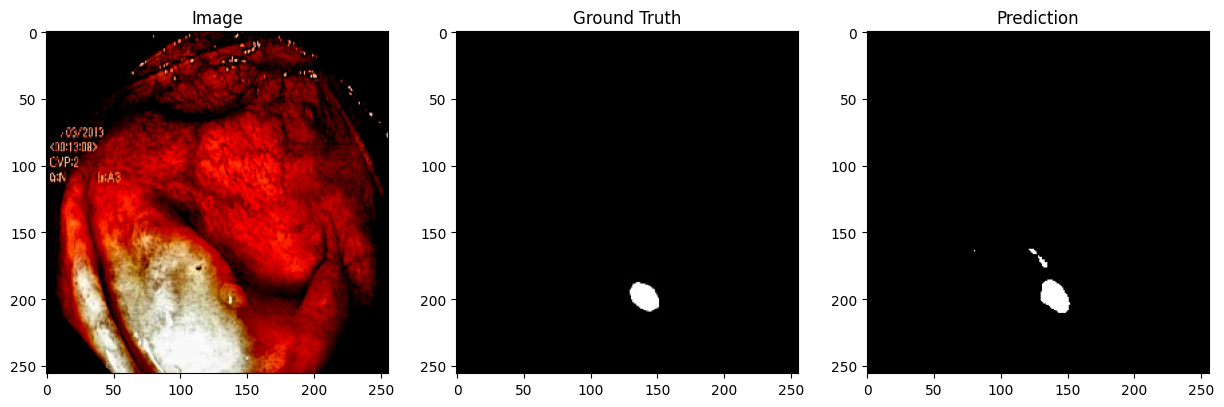

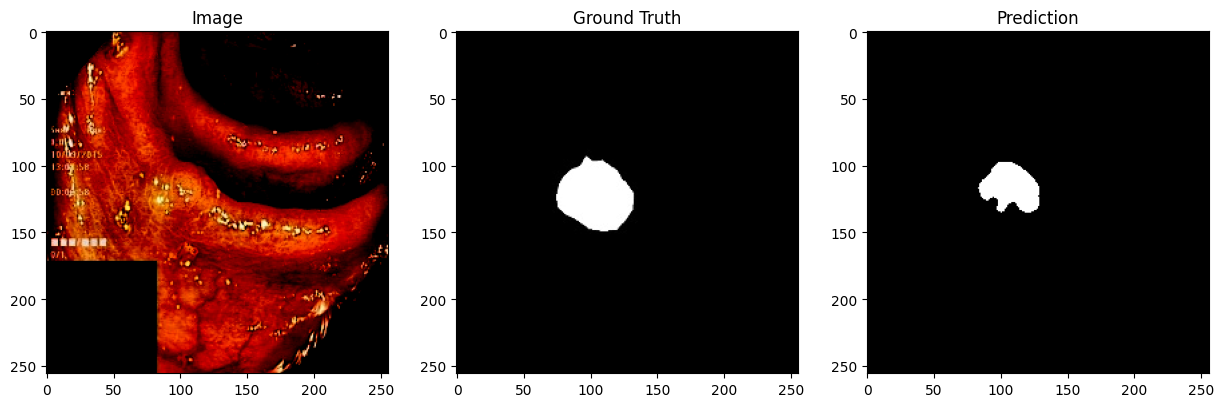

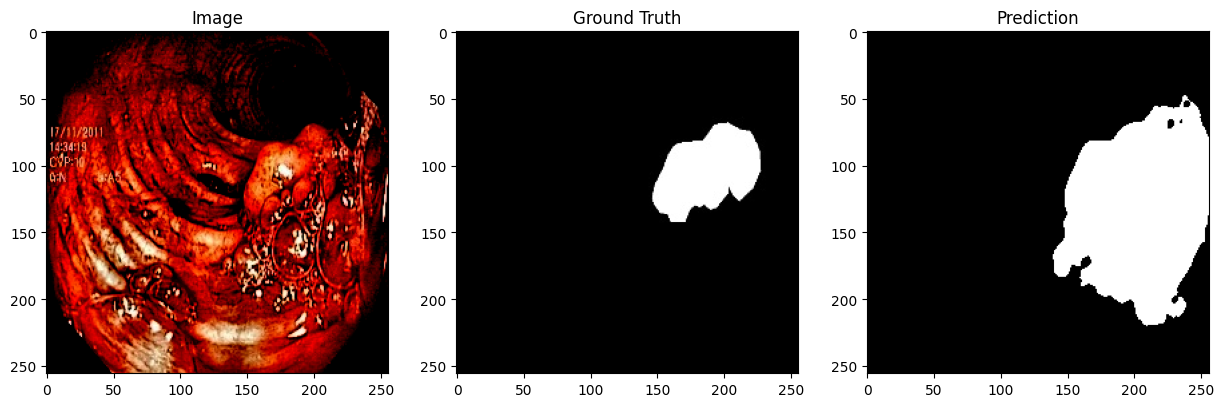

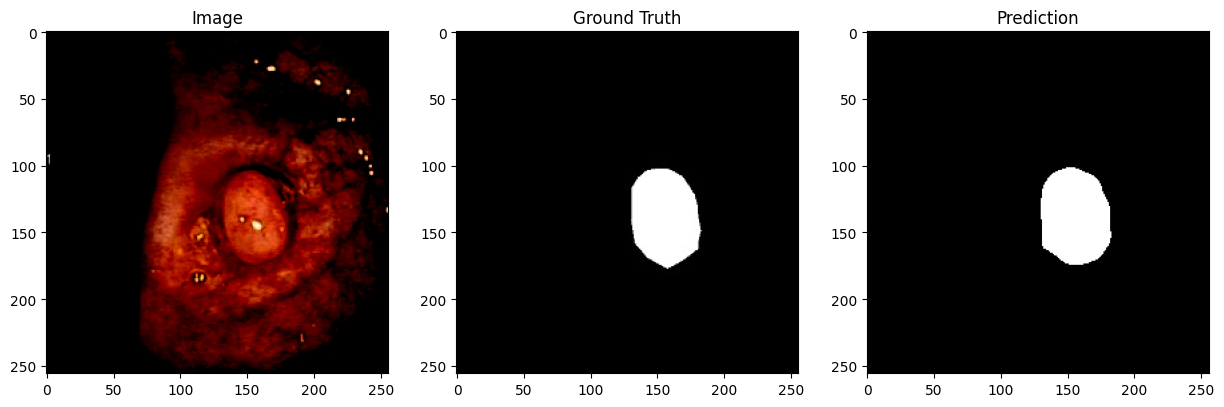

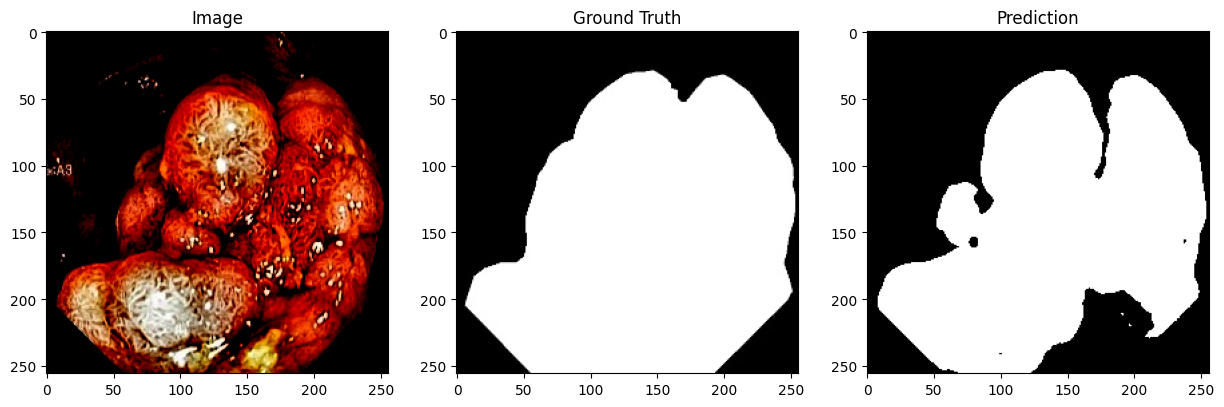

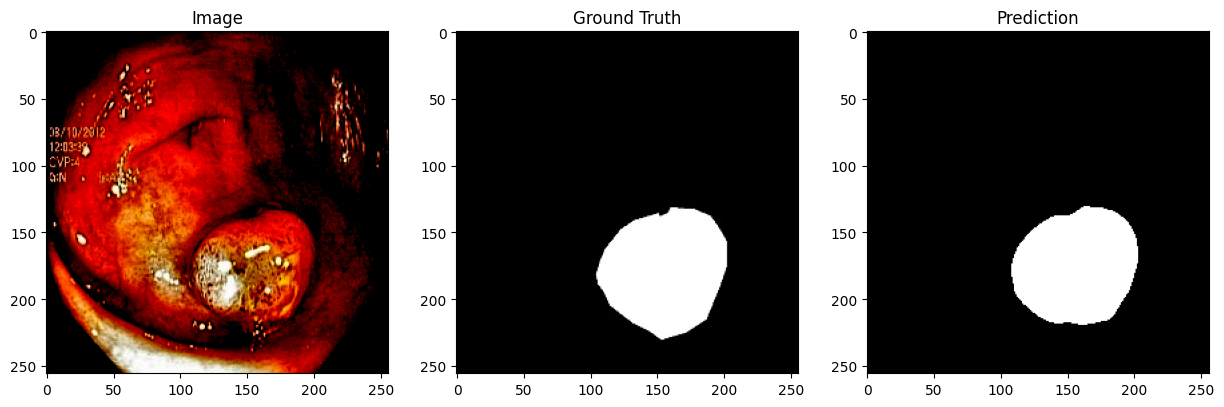

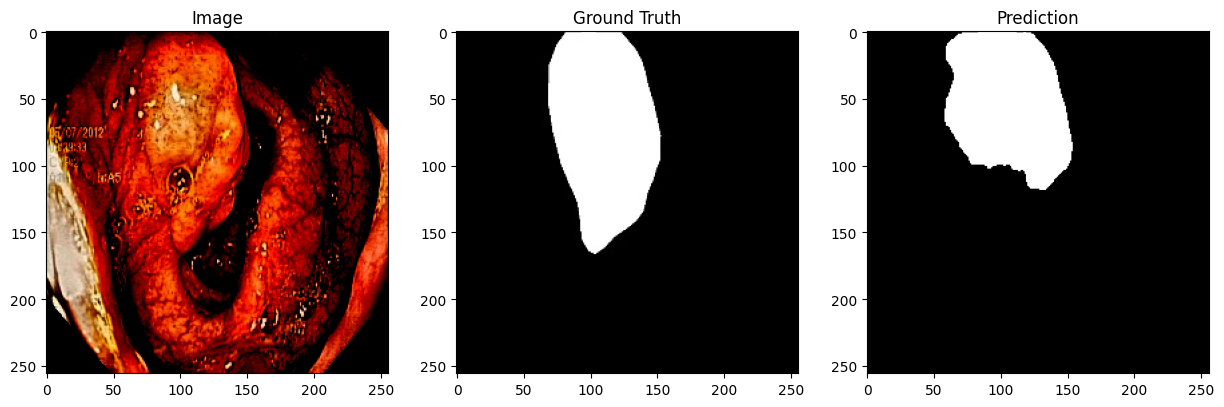

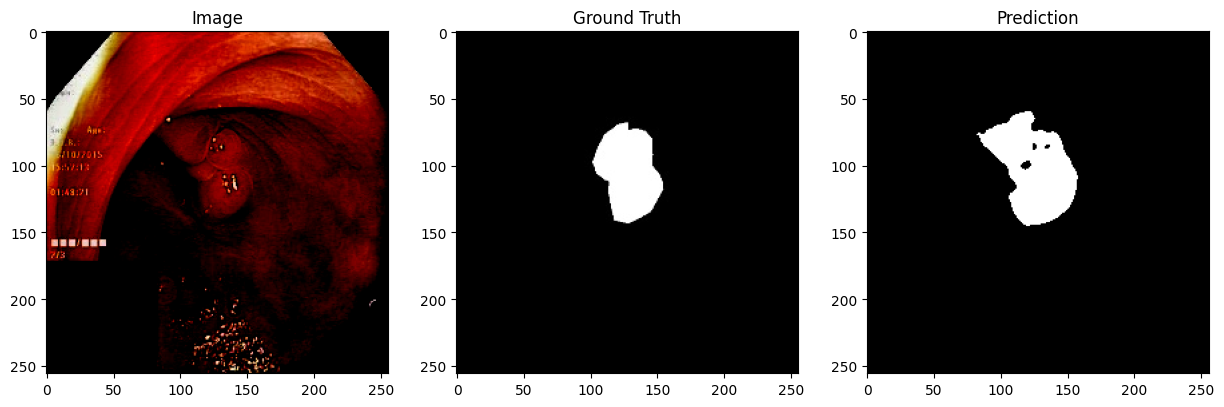

In [6]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5

        for j in range(images.size(0)):
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(images[j].permute(1,2,0).cpu())
            axs[0].set_title("Image")
            axs[1].imshow(masks[j][0].cpu(), cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[2].imshow(preds[j][0], cmap='gray')
            axs[2].set_title("Prediction")
            plt.show()

        break  # Just show one batch


In [7]:
import torch

# Dice Coefficient
def dice_coeff(pred, target):
    smooth = 1e-6
    intersection = torch.sum(pred * target)
    return 2. * intersection / (torch.sum(pred) + torch.sum(target) + smooth)

# Intersection over Union (IoU)
def iou_coeff(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    return intersection / (union + 1e-6)

# Accuracy: Pixel-wise accuracy
def accuracy(pred, target):
    correct = torch.sum(pred == target)
    total = torch.numel(target)
    return correct / total


In [8]:
model.eval()
with torch.no_grad():
    val_loss = 0
    val_dice = 0
    val_iou = 0
    val_accuracy = 0
    num_batches = len(valid_loader)
    
    for images, masks in tqdm(valid_loader, desc="Validation"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        preds = torch.sigmoid(outputs)  # Assuming outputs are logits (sigmoid for binary masks)
        
        # Binary thresholding
        preds = preds > 0.5  # Predicted mask (0 or 1)

        # Calculate loss (using Dice + IoU as a loss)
        loss = dice_coeff(preds, masks) + iou_coeff(preds, masks)
        val_loss += loss.item()

        # Calculate Dice, IoU, and Accuracy for metrics
        val_dice += dice_coeff(preds, masks).item()
        val_iou += iou_coeff(preds, masks).item()
        val_accuracy += accuracy(preds, masks).item()

    # Print metrics for validation
    print(f'Validation Loss: {val_loss / num_batches:.4f}')
    print(f'Validation Dice Score: {val_dice / num_batches:.4f}')
    print(f'Validation IoU: {val_iou / num_batches:.4f}')
    print(f'Validation Accuracy: {val_accuracy / num_batches:.4f}')


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.51it/s]

Validation Loss: 1.5690
Validation Dice Score: 0.8387
Validation IoU: 0.7303
Validation Accuracy: 0.9380


In [9]:
model.eval()
with torch.no_grad():
    test_dice = 0
    test_iou = 0
    test_accuracy = 0
    num_batches = len(test_loader)
    
    for images, masks in tqdm(test_loader, desc="Test"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        preds = torch.sigmoid(outputs)  # Assuming outputs are logits (sigmoid for binary masks)
        
        # Binary thresholding
        preds = preds > 0.5  # Predicted mask (0 or 1)

        # Calculate Dice, IoU, and Accuracy for metrics
        test_dice += dice_coeff(preds, masks).item()
        test_iou += iou_coeff(preds, masks).item()
        test_accuracy += accuracy(preds, masks).item()

    # Print metrics for test
    print(f'Test Dice Score: {test_dice / num_batches:.4f}')
    print(f'Test IoU: {test_iou / num_batches:.4f}')
    print(f'Test Accuracy: {test_accuracy / num_batches:.4f}')


Test: 100%|██████████| 25/25 [00:03<00:00,  7.60it/s]

Test Dice Score: 0.8833
Test IoU: 0.7952
Test Accuracy: 0.9417
